In [39]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gp
import plotly.express as px
import skill_metrics as sm
import skill_metrics as sm
import matplotlib.pyplot as plt
import scipy.stats as scs
import plotly.graph_objects as go
sys.path.append(r'C:\Users\Pooya\w\GitHub\ShiraziPooya\DroughtMonitoringIran')
from app.utils.model_evaluator import ModelEvaluator

### Load Monthly Data

In [23]:
DATABASE_PATH = "../database/database.db"
conn = sqlite3.connect(DATABASE_PATH)
data = pd.read_sql(sql='SELECT * FROM data', con=conn)
conn.close()

### Columns

In [24]:
data.columns.to_list()

['region_id',
 'region_name',
 'station_name',
 'station_id',
 'lat',
 'lon',
 'station_elevation',
 'date',
 'tmax',
 'tmin',
 'tm',
 'rrr24',
 'Hargreaves',
 'SPI_1',
 'SPEI_1',
 'SPI_3',
 'SPEI_3',
 'SPI_6',
 'SPEI_6',
 'SPI_9',
 'SPEI_9',
 'SPI_12',
 'SPEI_12',
 'SPI_15',
 'SPEI_15',
 'SPI_18',
 'SPEI_18',
 'SPI_21',
 'SPEI_21',
 'SPI_24',
 'SPEI_24',
 'CHIRPS',
 'ERA5',
 'GPM',
 'PERSIANN_CDR',
 'TRMM',
 'TerraClimate',
 'MOD16A2GF',
 'EVI_Aqua_MYD13A3',
 'EVI_Terra_MOD13A3',
 'LST_Day_Aqua_MYD21C3',
 'LST_Day_Terra_MOD21C3',
 'LST_Night_Aqua_MYD21C3',
 'LST_Night_Terra_MOD21C3',
 'NDVI_Aqua_MYD13A3',
 'NDVI_Terra_MOD13A3',
 'NDVI',
 'EVI',
 'LST_Day',
 'LST_Night',
 'LST',
 'PCI_ERA5',
 'PCI_GPM',
 'PCI_TRMM',
 'PCI_TerraClimate',
 'PCI_PERSIANN_CDR',
 'PCI_CHIRPS',
 'VCI',
 'TCI',
 'TCI_Day',
 'TCI_Night',
 'VHI',
 'VHI_Day',
 'VHI_Night',
 'CI_GPM',
 'CI_ERA5',
 'CI_TRMM',
 'CI_TerraClimate',
 'CI_PERSIANN_CDR',
 'CI_CHIRPS',
 'CHIRPS_SPI_1',
 'CHIRPS_SPEI_1',
 'ERA5_SPI_1',
 '

In [25]:
SELECTED_COLUMNS = [
    'region_id',
    'region_name',
    'station_name',
    'station_id',
    'lat',
    'lon',
    'station_elevation',
    'date',
    'rrr24',
    'CHIRPS',
    'ERA5',
    'GPM',
    'PERSIANN_CDR',
    'TRMM',
    'TerraClimate'
]

### Unique Station

In [26]:
data[[
    'region_id',
    'region_name',
    'station_name',
    'station_id'
]].drop_duplicates().reset_index(drop=True)

,region_id,region_name,station_name,station_id
0,MASA,Mazandaran,Ramsar,40732
1,MASA,Mazandaran,Nowshahr,40734
2,MASA,Mazandaran,Siahbisheh,40735
3,MASA,Mazandaran,Babolsar,40736
4,MASA,Mazandaran,Gharakhil,40737
5,MASA,Mazandaran,Sari,40759
6,MASA,Mazandaran,Kiyasar,40760
7,MASA,Mazandaran,Sari (Dasht-E-Naz Airport),40788
8,MASA,Mazandaran,Galugah,99299
9,MASA,Mazandaran,Bandar-E-Amirabad,99306


### Select Regions and Stations
- Cluster 1 - Sari:40759
- Cluster 2 - Alasht:99361  
- Cluster 3 - Ramsar:40732

In [27]:
SELECTED_REGIONS = ["Mazandaran"]
SELECTED_STATIONS = ["Sari", "Alasht", "Ramsar"]

### Selected Date Range

In [28]:
START_DATE = "2005-09-01"
END_DATE = "2024-09-01"

## Filter Data

In [29]:
selected_data = data \
    .query('region_name == @SELECTED_REGIONS') \
        .query('station_name == @SELECTED_STATIONS') \
            .query("date >= @START_DATE and date < @END_DATE") \
                .filter(items=SELECTED_COLUMNS)

selected_data

,region_id,region_name,station_name,station_id,lat,lon,station_elevation,date,rrr24,CHIRPS,ERA5,GPM,PERSIANN_CDR,TRMM,TerraClimate
309,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-10,116.10,90.368,331.979,107.136,34.573,87.828,146.0
310,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-11,61.22,134.801,167.927,100.800,56.969,93.468,144.0
311,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-12,54.13,162.861,123.151,55.056,45.104,61.831,75.0
312,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2006-01,78.12,179.211,221.942,101.928,99.951,115.673,108.0
313,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2006-02,21.83,132.907,106.635,51.072,56.901,39.602,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8218,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-05,49.11,52.236,191.930,52.080,52.798,NaN,24.0
8219,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-06,158.21,57.173,99.149,59.760,41.765,NaN,11.0
8220,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-07,52.81,40.035,67.956,14.880,4.405,NaN,8.0
8221,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-08,36.42,40.107,61.407,12.648,12.072,NaN,4.0


### TaylorDiagram Precip (for each station)

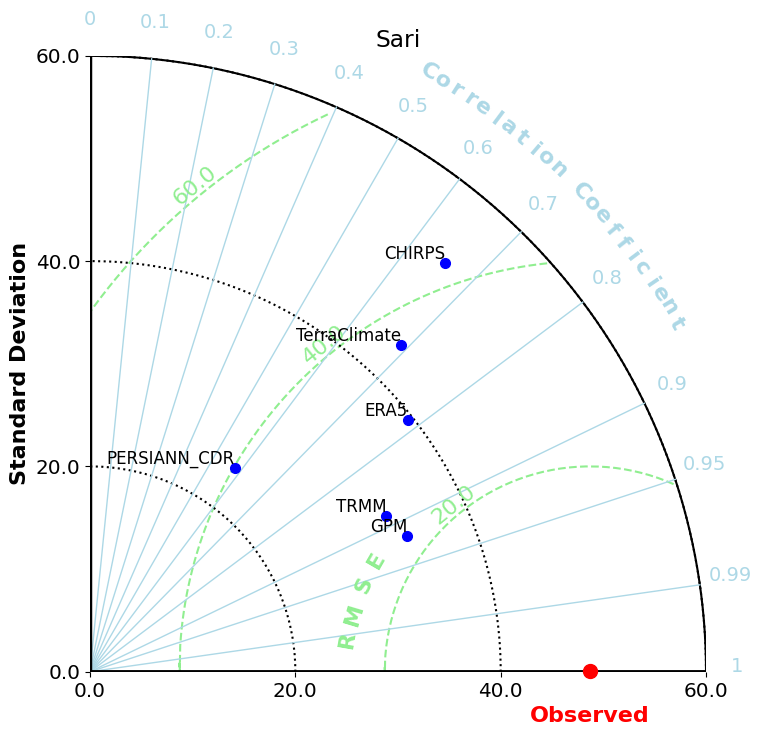

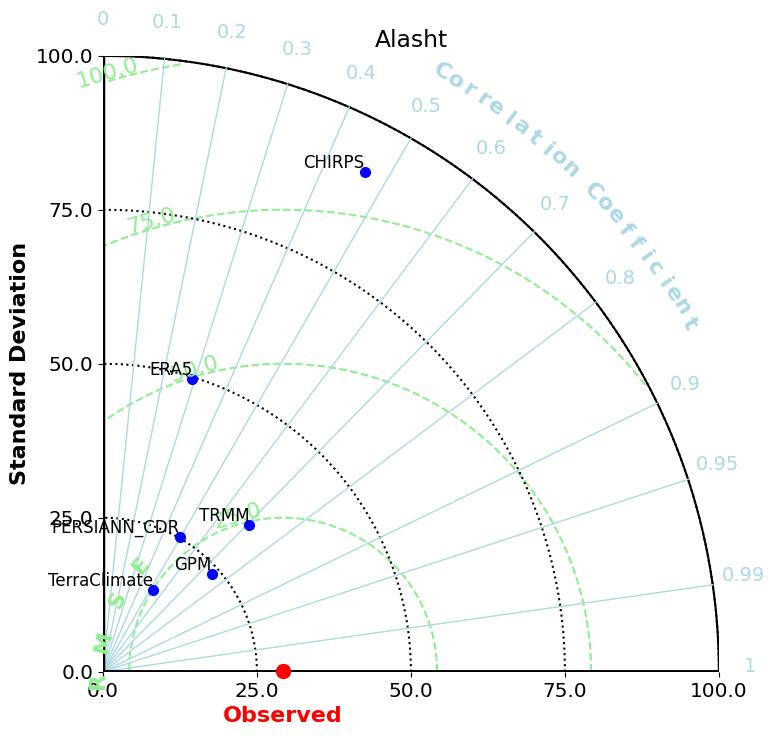

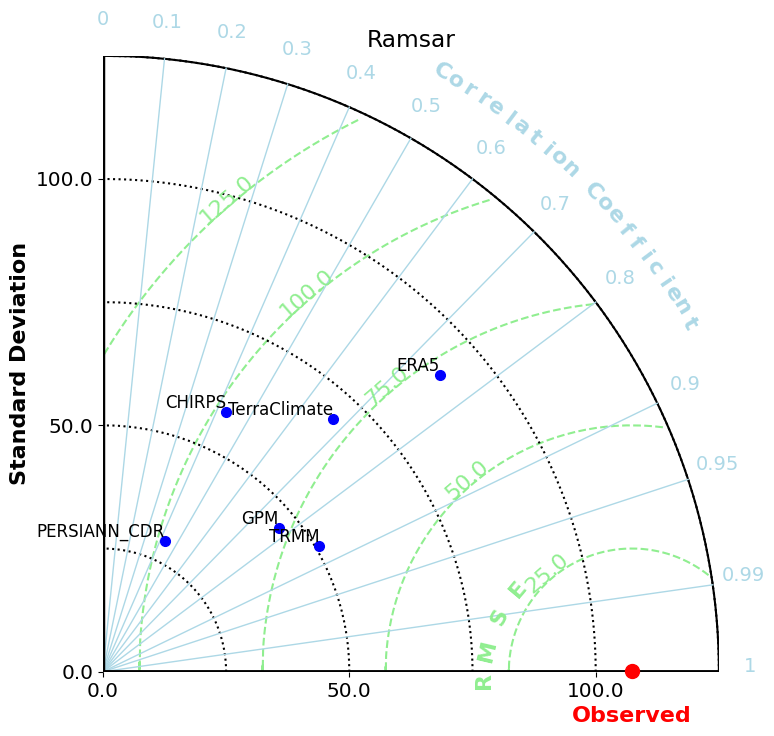

In [33]:
for sti in SELECTED_STATIONS:
    df = selected_data.query(f"station_name == '{sti}'")
    
    observed_name = 'rrr24'
    models_name = ['CHIRPS', 'ERA5', 'GPM', 'TRMM', 'TerraClimate', 'PERSIANN_CDR']
    
    std_mods = []
    correlations = []
    rmses = []
    std_obss = []

    for model in models_name:
        valid_data = df[[observed_name, model]].dropna()
        
        observed_values = valid_data[observed_name].values
        modeled_values = valid_data[model].values

        std_mod = np.std(modeled_values)
        std_obs = np.std(observed_values)
        cor = np.corrcoef(observed_values, modeled_values)[0, 1]
        rmse = np.sqrt(np.mean((observed_values - modeled_values) ** 2))
        
        std_mods.append(std_mod)
        std_obss.append(std_obs)
        correlations.append(cor)
        rmses.append(rmse)

    std_mods.insert(0, np.std(df['rrr24'].dropna()))
    rmses.insert(0, 0)
    correlations.insert(0, 1)

    std_mods = np.array(std_mods)
    correlations = np.array(correlations)
    rmses = np.array(rmses)
    std_obss = np.array(std_obss)

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(8, 8))
    sm.taylor_diagram(
        std_mods, rmses, correlations,
        markerdisplayed='marker',
        markerLabel=['Observed'] + models_name,
        markerColor='blue',
        markerSize=14,
        colCOR='lightblue',
        colrms='lightgreen',
        colstd='black',
        styleCOR='-',
        widthCOR=1,
        titleOBS='Observed',
        # styleOBS='-',
        colOBS='red',
        labelrms="RMSE",
        markerobs = 'o'
    )
    # plt.legend(loc="upper right")
    plt.title(f"{sti}")
    plt.show()

### Calculate Model Evaluator

In [ ]:
for pr_model in models_name:
    for sid, df in data.query("station_name in @SELECTED_STATIONS").groupby(by='station_name'):
        print(f"\nMetrics for Station ID: {sid} and Precip Model: {pr_model}")
        ModelEvaluator(df, observed_name, pr_model).display_metrics()


Metrics for Station ID: Alasht and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 76.8667
Mean Squared Error (MSE): 11565.5956
Root Mean Squared Error (RMSE): 107.5435
R-squared (R2): -13.1431
Explained Variance Score: -7.2220
Willmott's Index of Agreement (WI): 0.2364
Nash–Sutcliffe Efficiency (NS): -13.1431
Mean Absolute Deviation (MAD): 76.8667

Metrics for Station ID: Ramsar and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 62.6146
Mean Squared Error (MSE): 10910.7078
Root Mean Squared Error (RMSE): 104.4543
R-squared (R2): 0.0554
Explained Variance Score: 0.0810
Willmott's Index of Agreement (WI): 0.4859
Nash–Sutcliffe Efficiency (NS): 0.0554
Mean Absolute Deviation (MAD): 62.6146

Metrics for Station ID: Sari and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 33.8252
Mean Squared Error (MSE): 2079.8203
Root Mean Squared Error (RMSE): 45.6050
R-squared (R2): 0.0784
Explained Variance Score: 0.176

In [41]:
for st in SELECTED_STATIONS:
    station_data = data.query("station_name == @st")[['date', 'rrr24', 'GPM']].dropna()

    fig = px.scatter(
        station_data,
        x='rrr24',
        y='GPM',
        labels={
            "rrr24": f"{st}<br>Observed Precipitation (mm)",
            "GPM": "GPM Estimated Precipitation (mm)"
        },
        opacity=0.7,
        color_discrete_sequence=["black"],
    )

    fig.update_traces(marker=dict(size=8, color="black"))

    max_limit = max(station_data['rrr24'].max(),
                    station_data['GPM'].max()) + 50
    
    tick_vals = np.arange(0, max_limit + 1, 50)

    fig.update_layout(
        xaxis=dict(range=[0, max_limit], tickvals=tick_vals),
        yaxis=dict(range=[0, max_limit], tickvals=tick_vals),
        width=600,
        height=600,
        title=None,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    fig.add_trace(go.Scatter(
        x=[0, max_limit],
        y=[0, max_limit],
        mode="lines",
        line=dict(color="red", dash="dash"),
        showlegend=False
    ))

    fig.show()
